In [22]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime

MONGO_CLIENT = MongoClient("mongodb://localhost:27017/")

In [25]:
communities = ["neuroscience_expanded", "science_fiction_expanded", "chess", "math", "urban_planning", "game_development", "climate_change_expanded"]
summary_data = []
start_date_str = "2024-07-01T00:00:00.000Z"
end_date_str = "2025-03-01T00:00:00.000Z"

for db in communities:
    user_collection = MONGO_CLIENT[db]['user_info']
    user_df = pd.DataFrame(list(user_collection.find()))
    
    core = user_collection.find_one({"rank": 0})
    core_user = core["userid"]

    consumers = [x for x in core["local follower list"]]

    producers = core["local following list"]
    producer_df = user_df[user_df['userid'].isin(producers)]
    producer_df = producer_df[producer_df['local following list'].apply(lambda x: core_user in x)]

    producers = producer_df['userid'].to_list()

    num_producers = len(producers)
    num_consumers = len(consumers)

    # get the tweets 
    original_tweets_collection = MONGO_CLIENT[db]['original_tweets']
    retweet_collection = MONGO_CLIENT[db]['retweets_of_in_community']

    date_filter = {
        "created_at": {
            "$gte": start_date_str,
            "$lt": end_date_str
        }
    }
    
    core_original_tweets_count = original_tweets_collection.count_documents({
        "user_id": core_user,
        **date_filter
    })

    producer_original_tweets_count = original_tweets_collection.count_documents({
        "user_id": {"$in": producers},
        **date_filter
    })

    retweet_count = retweet_collection.count_documents({
        "user_id": {"$in": consumers + [core_user]},
        **date_filter
    })

    summary_data.append({
        "Community": db,
        "Producers": num_producers,
        "Consumers": num_consumers,
        "Core Original Tweets": core_original_tweets_count,
        "Producers Original Tweets": producer_original_tweets_count,
        "Consumers+Core Retweets": retweet_count
    })

summary_df = pd.DataFrame(summary_data)
styled_df = summary_df.style.set_caption("Community Activity Summary") \
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#333'),
                   ('font-size', '18px'),
                   ('font-weight', 'bold'),
                   ('padding', '10px')]},
        {'selector': 'th',
         'props': [('background-color', '#f0f4f8'),
                   ('color', '#333'),
                   ('padding', '8px'),
                   ('font-size', '14px')]},
        {'selector': 'td',
         'props': [('padding', '8px'),
                   ('font-size', '13px')]}
    ]) \
    .format(precision=0, thousands=",") \
    .highlight_max(axis=0, props='font-weight:bold; color:#2E7D32;') \
    .highlight_min(axis=0, props='font-weight:bold; color:#C62828;')

# Display styled DataFrame (best in Jupyter notebook)
display(styled_df)


In [8]:
from collections import defaultdict


communities = ["astronomy", "climate_change", "comics"]

overlap_counts = defaultdict(dict)

for db in communities:
    user_collection = MONGO_CLIENT[db]['user_info']
    user_df = pd.DataFrame(list(user_collection.find()))
    
    core = user_collection.find_one({"rank": 0})
    core_user = core["userid"]
    producers = core["local following list"]
    producer_df = user_df[user_df['userid'].isin(producers)]
    producer_df = producer_df[producer_df['local following list'].apply(lambda x: core_user in x)]

    producers = set(producer_df['userid'])
    
    for rank in range(1, 4):  # Comparing with rank 1, 2, 3
        rank_user = user_collection.find_one({"rank": rank})
        rank_id = rank_user["userid"]
        rank_producers = rank_user["local following list"]
        producer_df = user_df[user_df['userid'].isin(rank_producers)]
        producer_df = producer_df[producer_df['local following list'].apply(lambda x: rank_id in x)]

        rank_producers = set(producer_df['userid'])
        
        intersection_count = len(producers & rank_producers)
        overlap_counts[db][f"Core vs Rank {rank}"] = intersection_count
        overlap_counts[db][f"Rank {rank} Follower Count"] = len(rank_producers)
    overlap_counts[db]["Core Producer Count"] = len(producers)
df_overlap = pd.DataFrame(overlap_counts).T
df_overlap

Core vs Rank 1  Rank 1 Follower Count  Core vs Rank 2  \
astronomy                   42                     48              48   
climate_change              69                     91              33   
comics                      81                    103              62   

                Rank 2 Follower Count  Core vs Rank 3  Rank 3 Follower Count  \
astronomy                          55              55                     60   
climate_change                     51              57                     82   
comics                             84              72                     95   

                Core Producer Count  
astronomy                        87  
climate_change                   78  
comics                          153

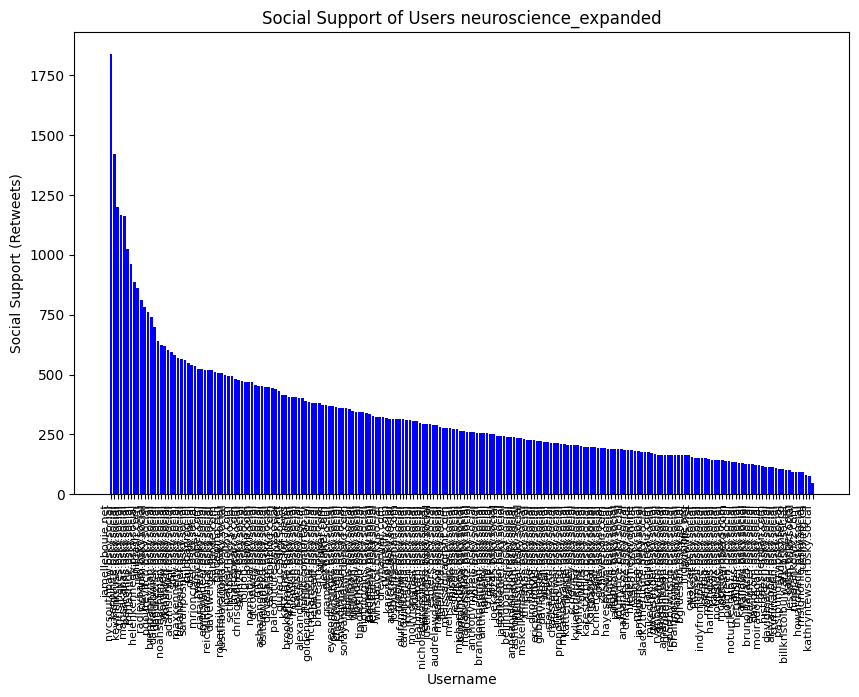

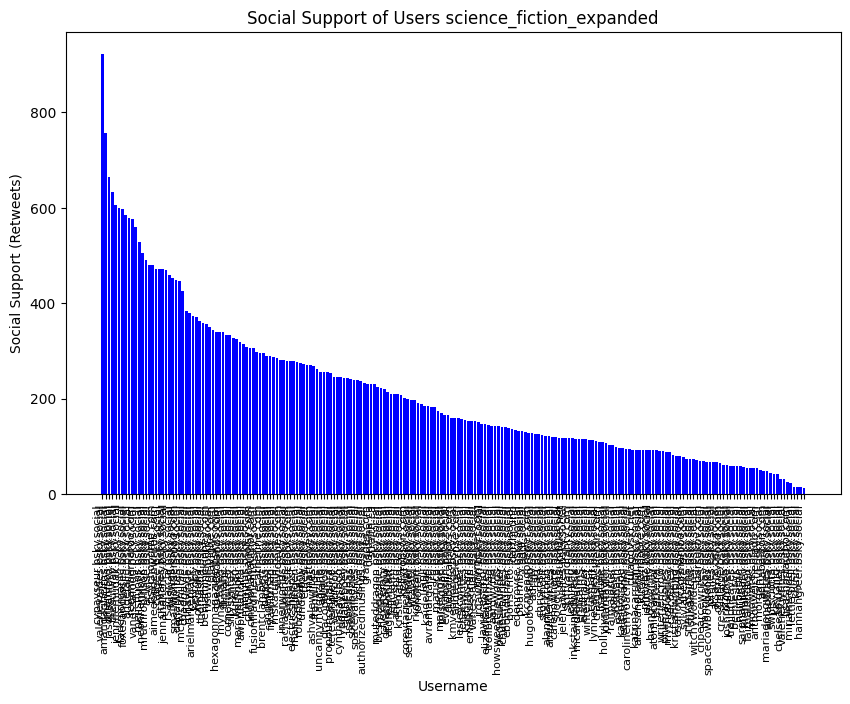

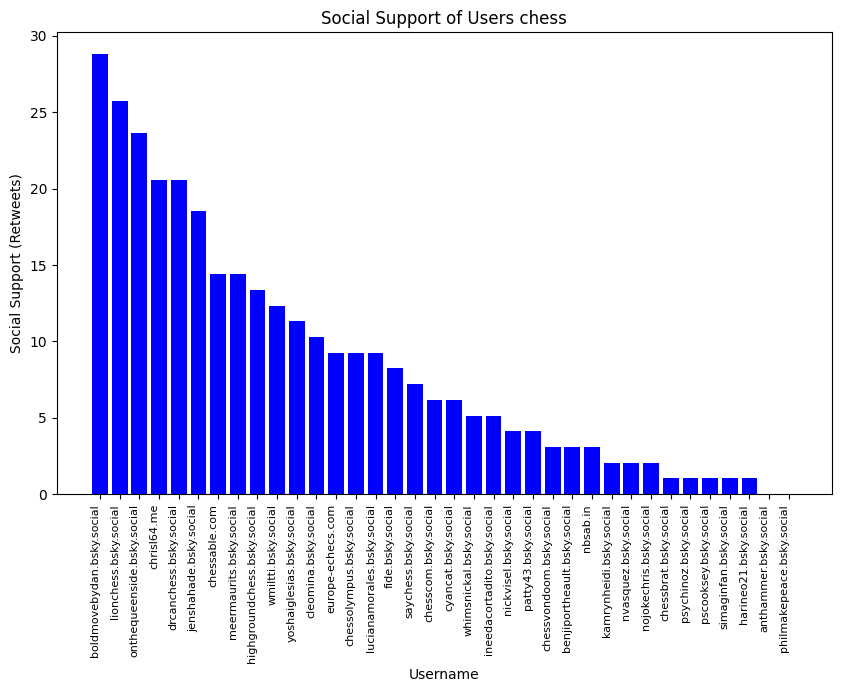

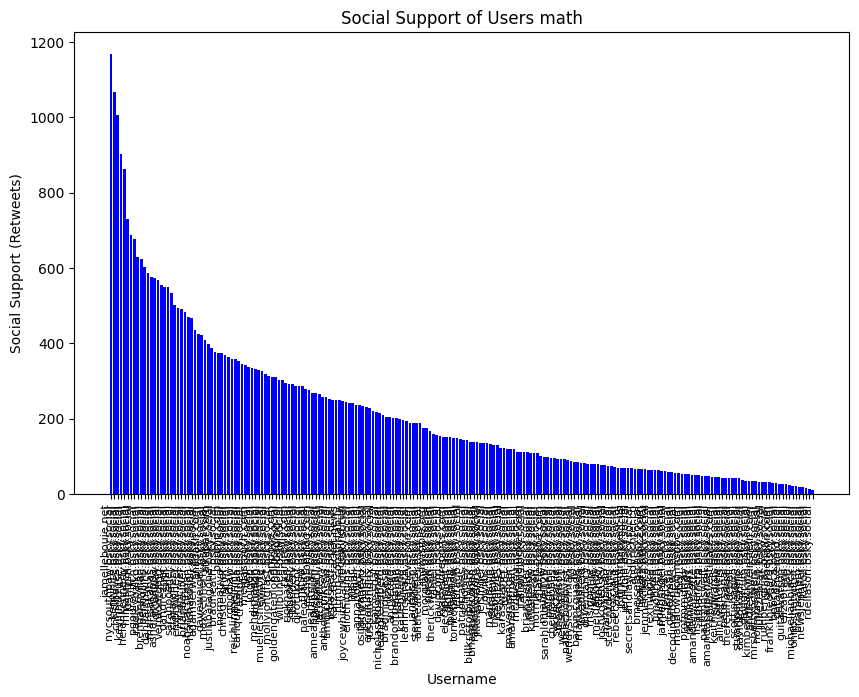

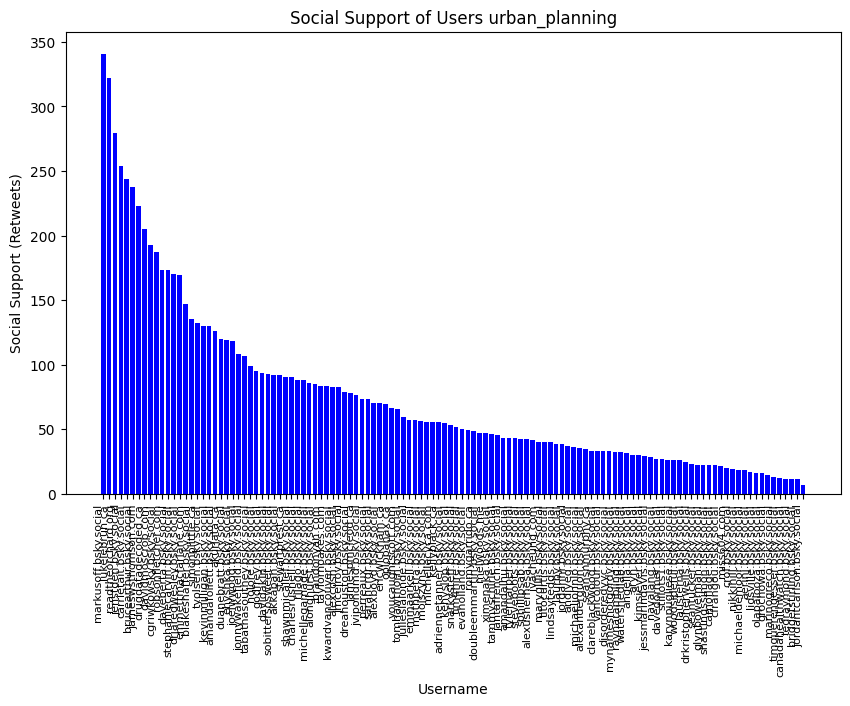

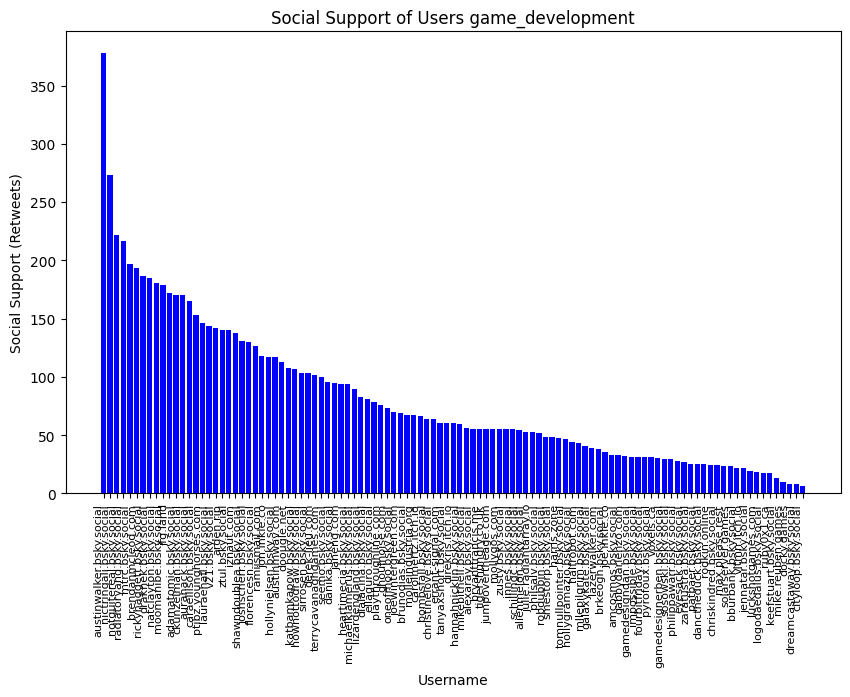

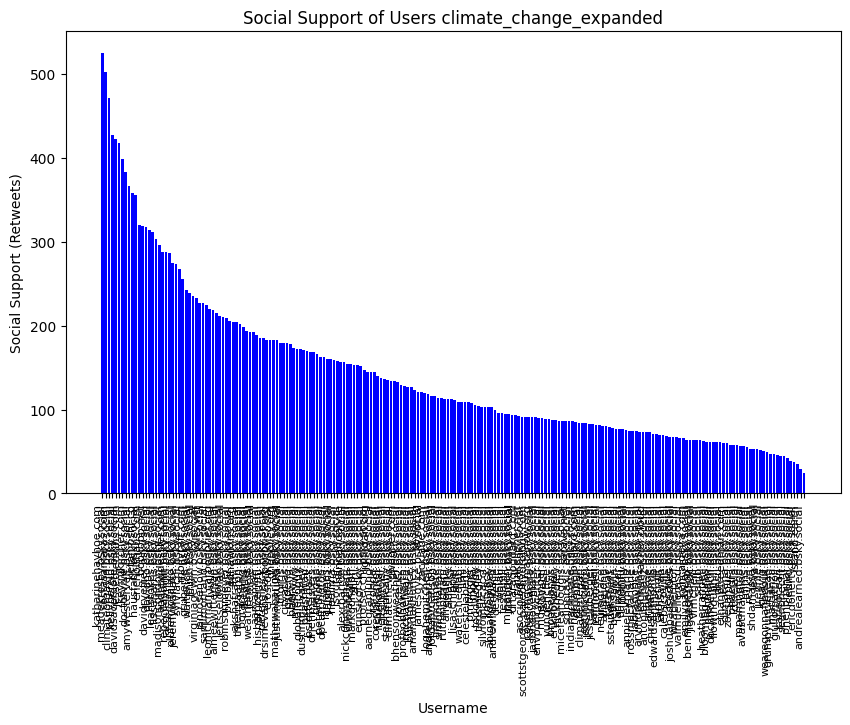

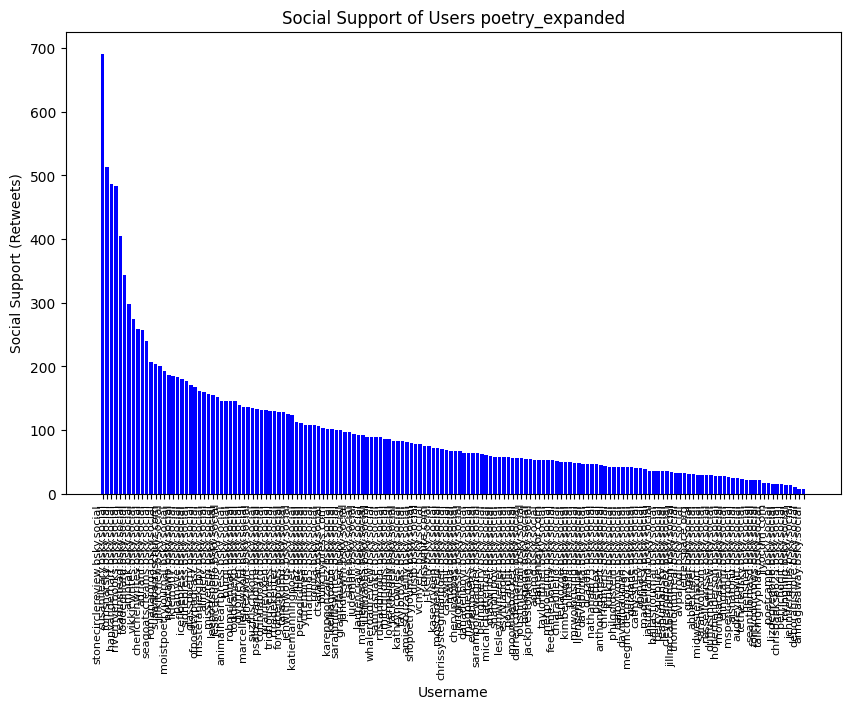

In [27]:
communities = ["neuroscience_expanded", "science_fiction_expanded", "chess", "math", "urban_planning", "game_development", "climate_change_expanded", "poetry_expanded"]
for db in communities:
    user_collection = MONGO_CLIENT[db]['user_info']
    user_df = pd.DataFrame(list(user_collection.find()))

    df = user_df.sort_values(by="retweets (social support)", ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(df["username"], df["retweets (social support)"], color="blue")
    plt.xlabel("Username")
    plt.ylabel("Social Support (Retweets)")
    plt.title(f"Social Support of Users {db}")
    plt.xticks(rotation=90, ha="right", fontsize=8)  # Adjust fontsize
    plt.show()


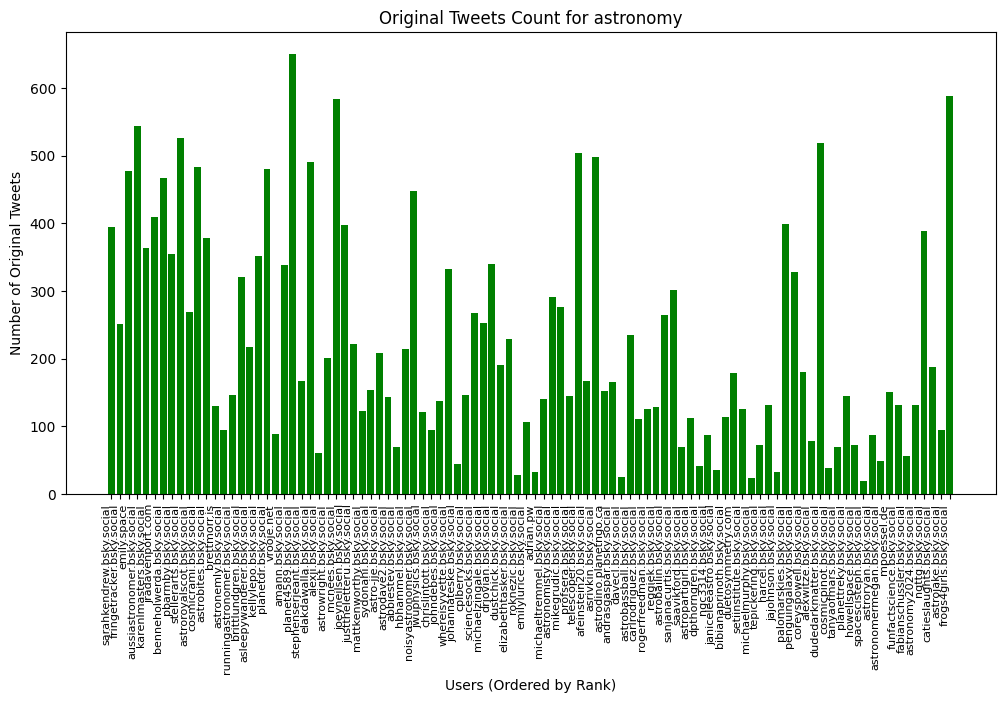

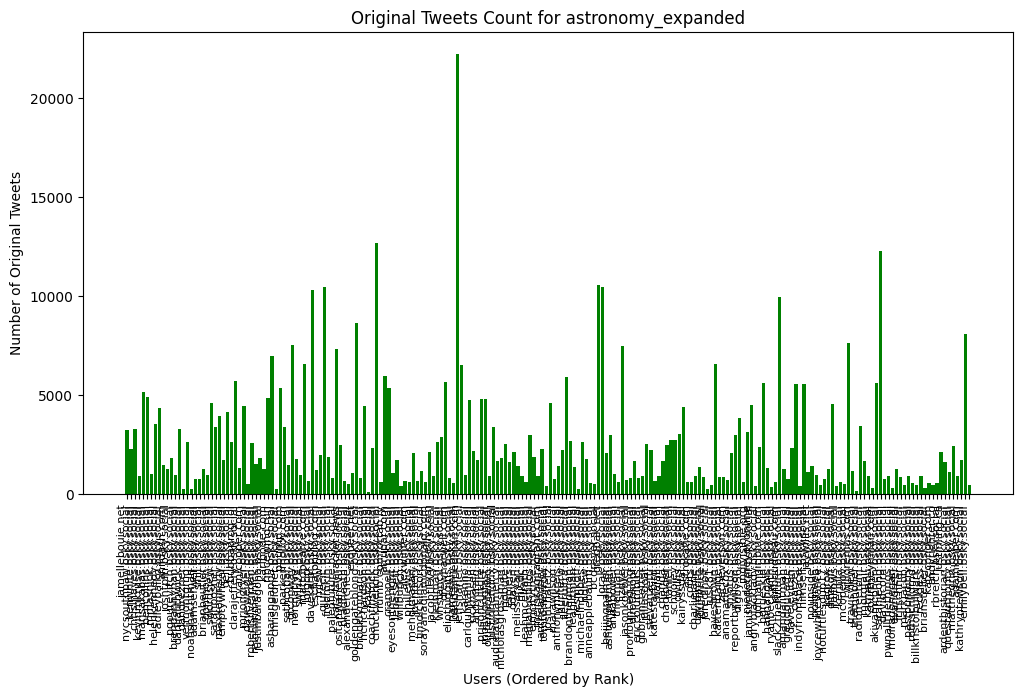

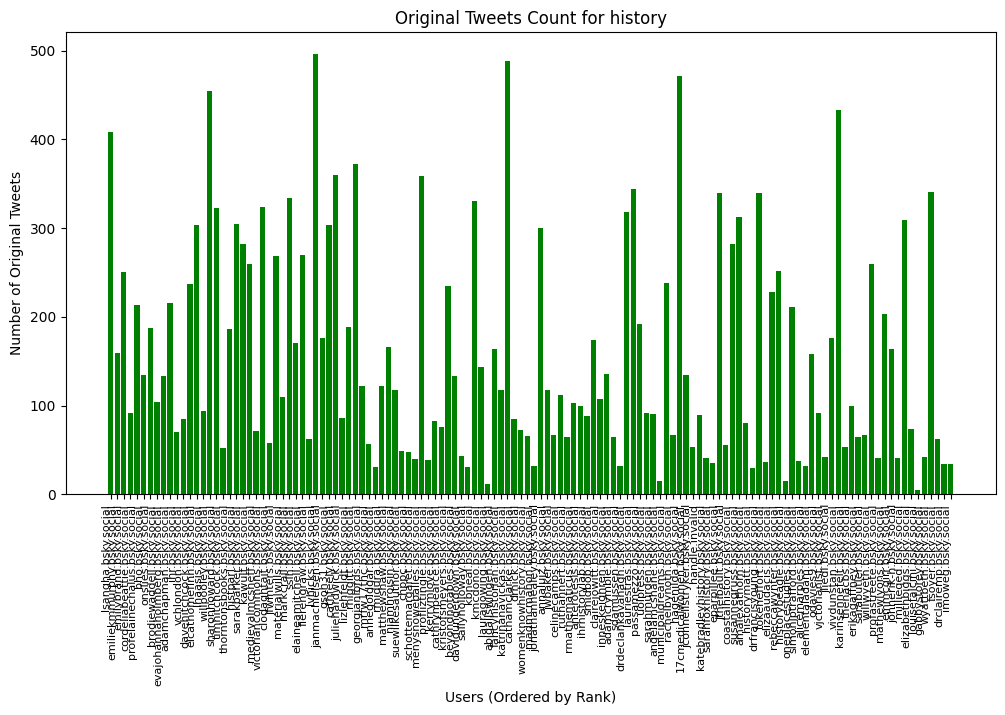

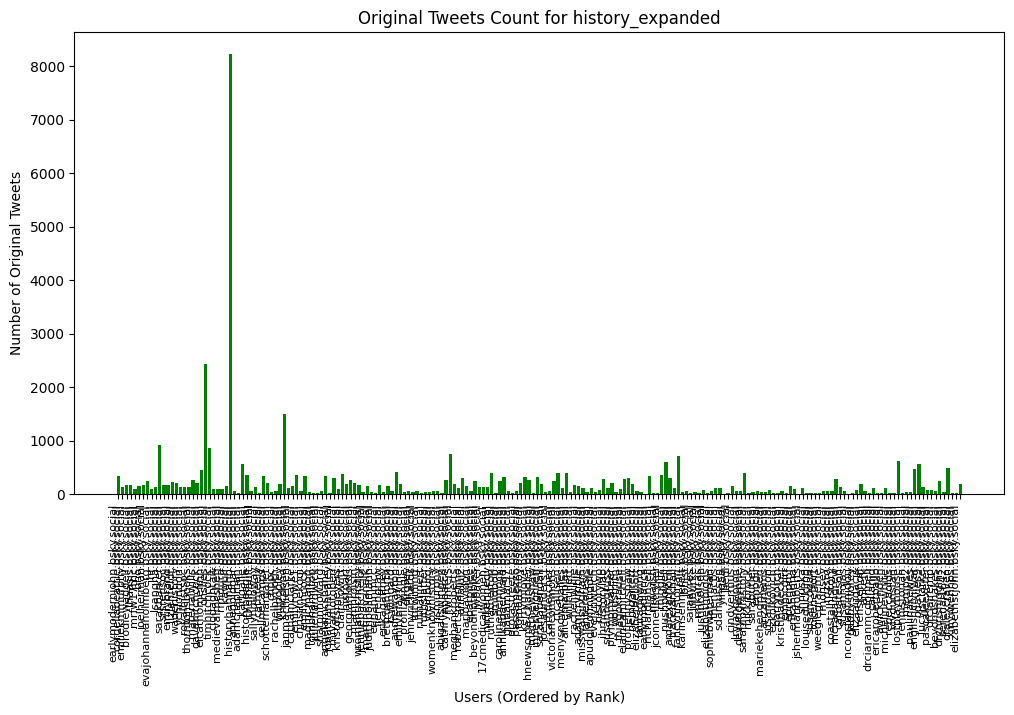

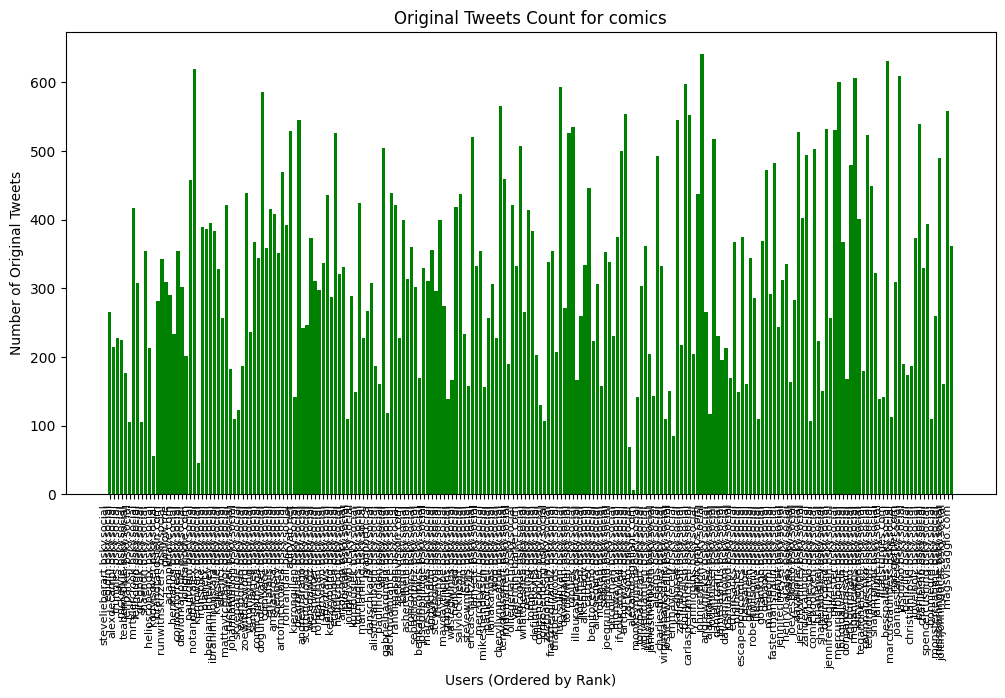

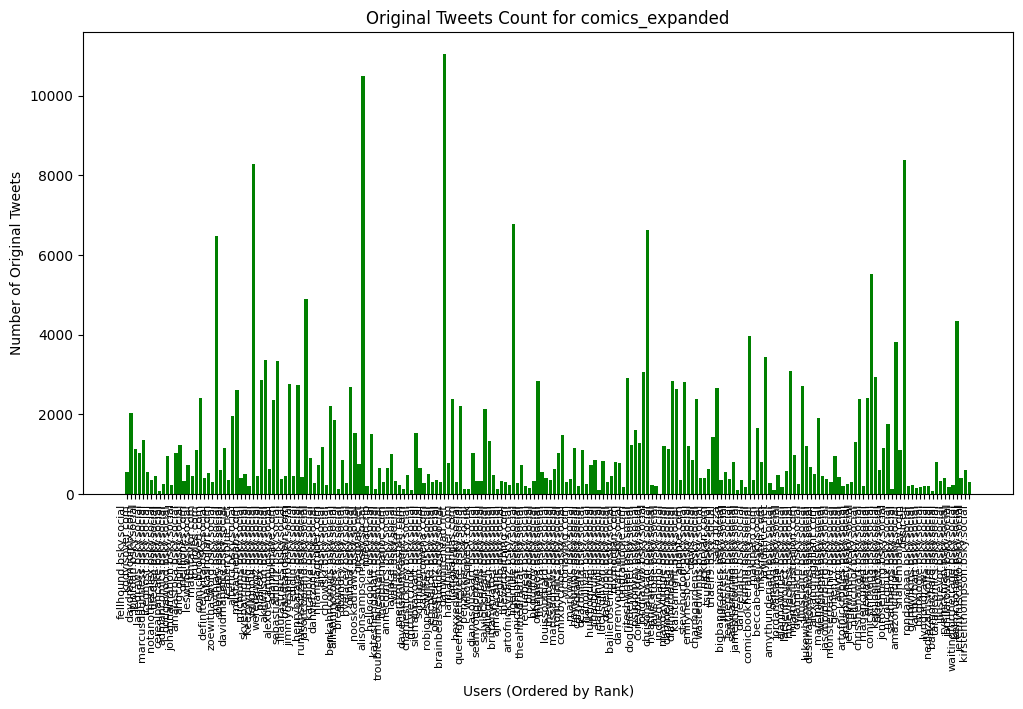

In [5]:

for db in communities:
    user_data = []
    user_collection = MONGO_CLIENT[db]['user_info']
    tweet_collection = MONGO_CLIENT[db]['original_tweets']

    users = user_collection.find({}, {"userid": 1, "username": 1, "rank": 1, "_id": 0}).sort("rank", 1)

    for user in users:
        user_id = user.get("userid")
        username = user.get("username")
        rank = user.get("rank")
        
        tweet_count = tweet_collection.count_documents({"user_id": user_id})
        
        user_data.append({"username": username, "rank": rank, "tweet_count": tweet_count})

    df = pd.DataFrame(user_data)

    df = df.sort_values(by="rank", ascending=True)

    plt.figure(figsize=(12, 6))
    plt.bar(df["username"], df["tweet_count"], color="green")
    plt.xlabel("Users (Ordered by Rank)")
    plt.ylabel("Number of Original Tweets")
    plt.title(f"Original Tweets Count for {db}")
    plt.xticks(rotation=90, ha="right", fontsize=8)
    plt.show()

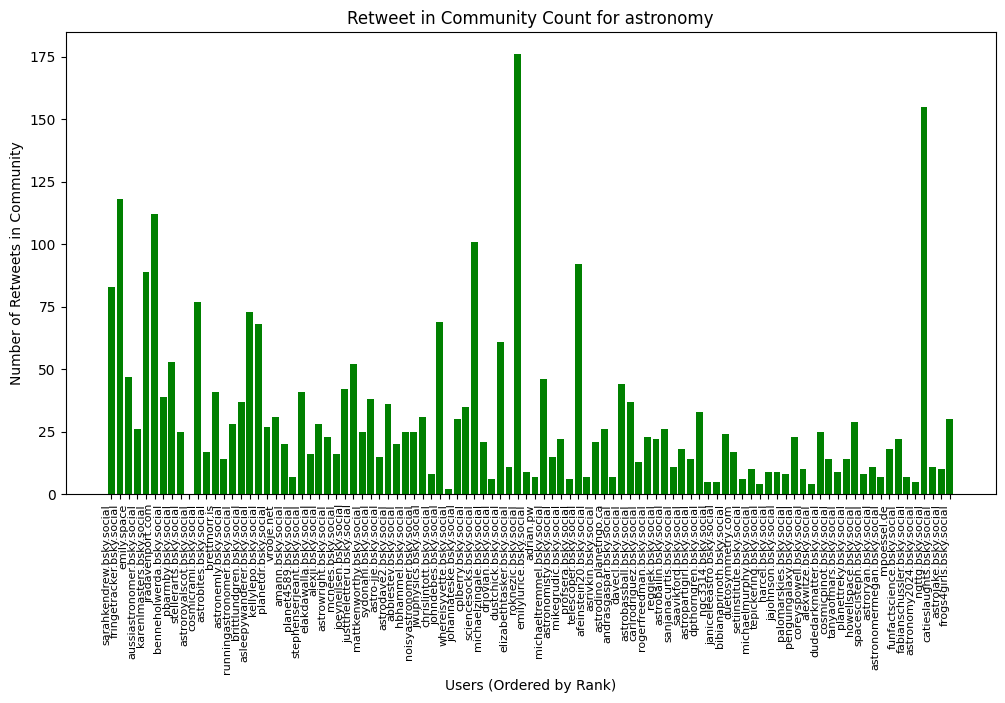

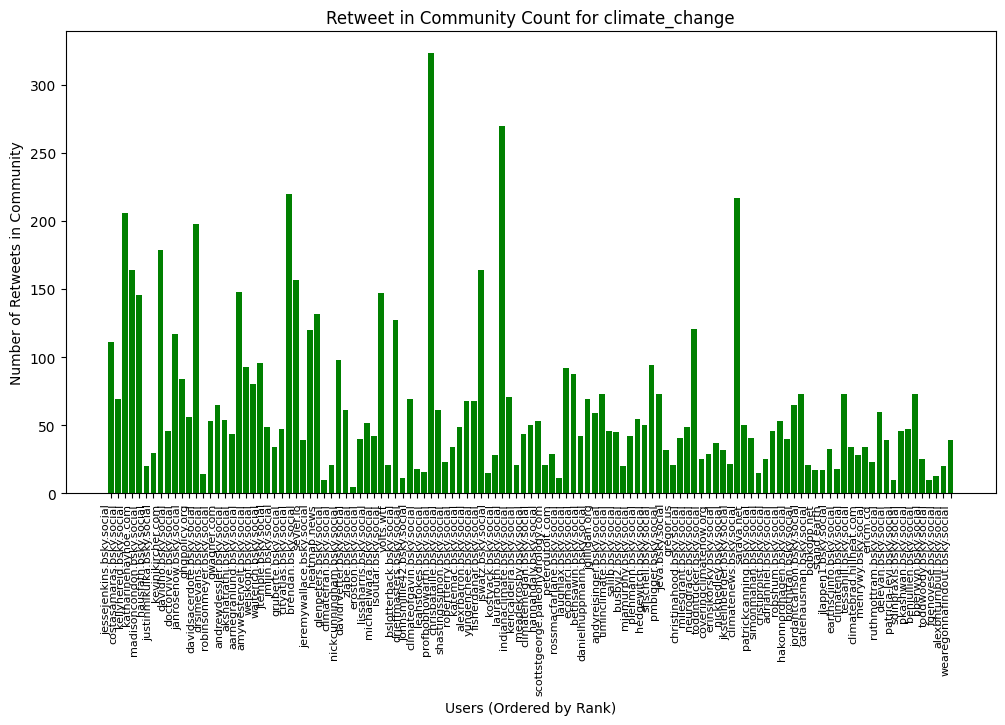

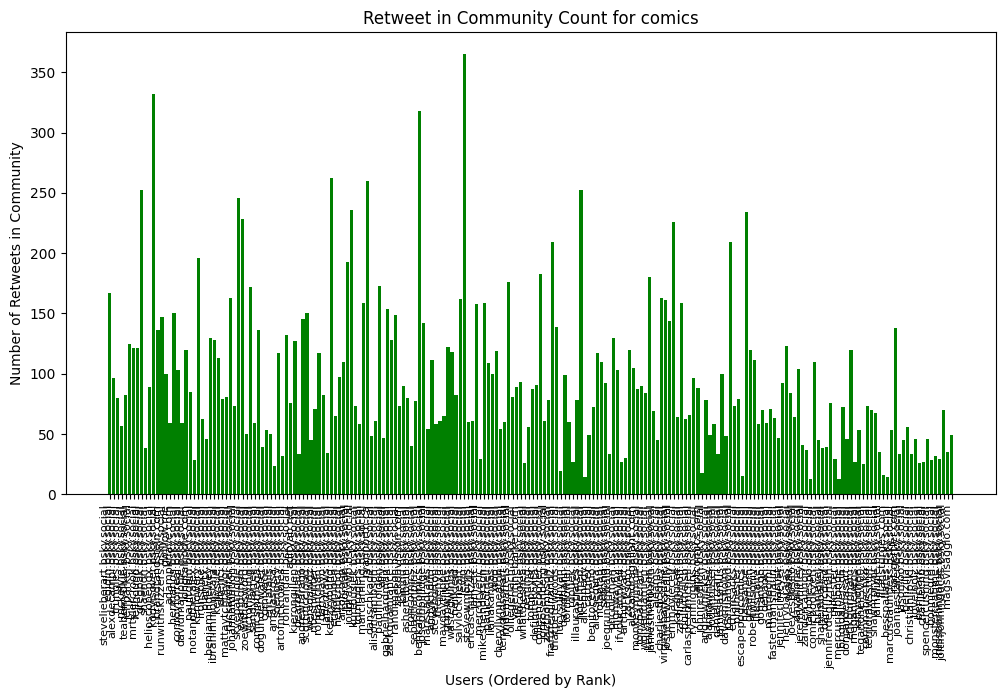

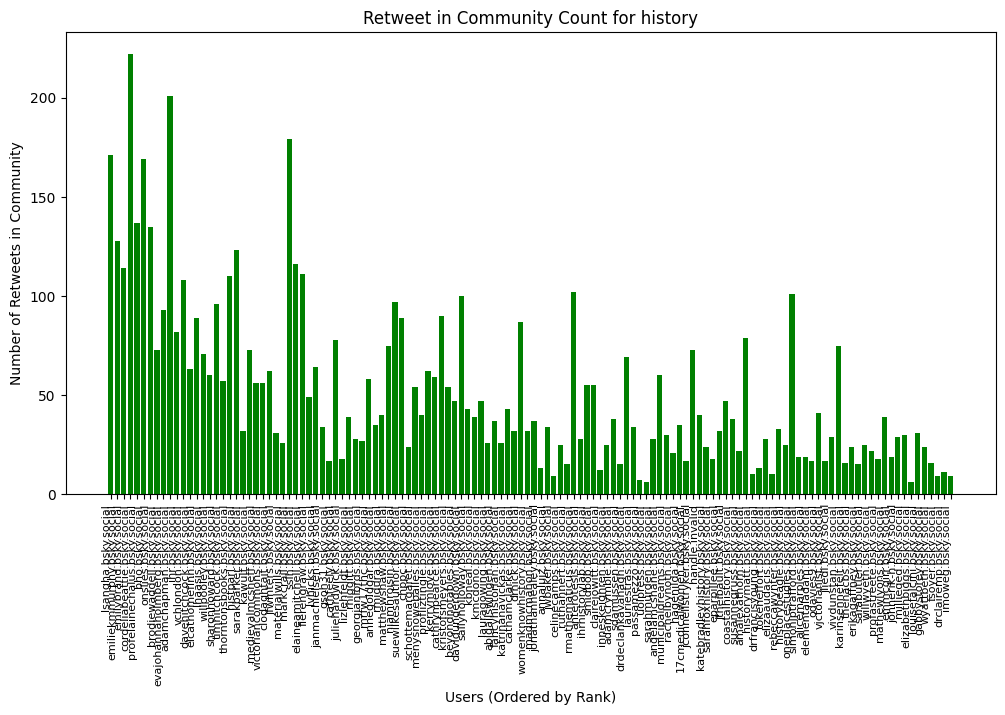

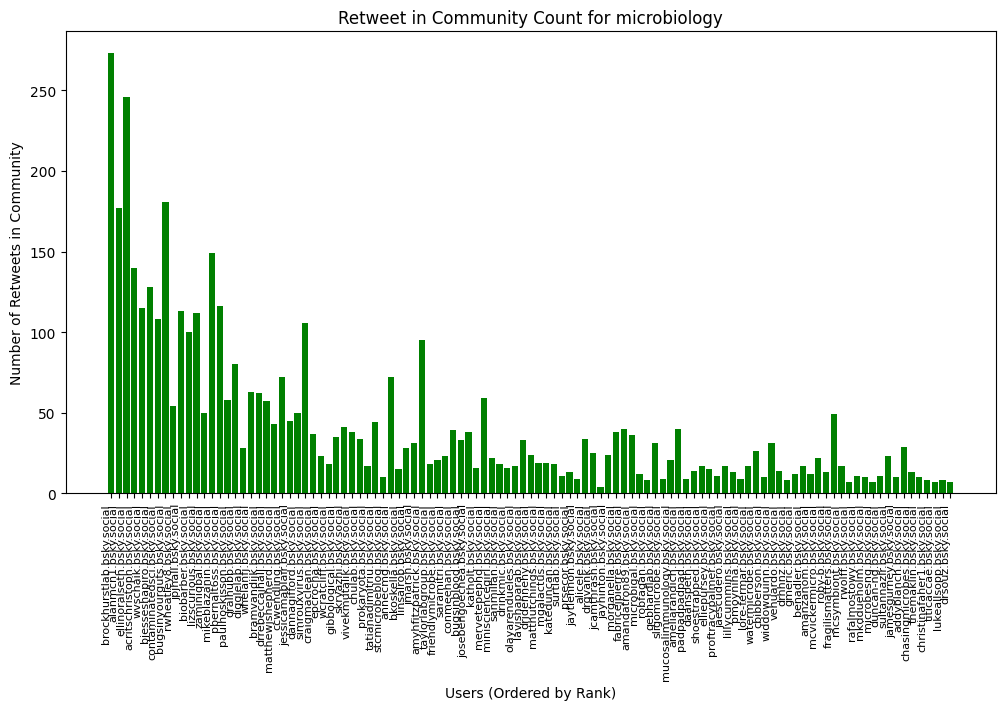

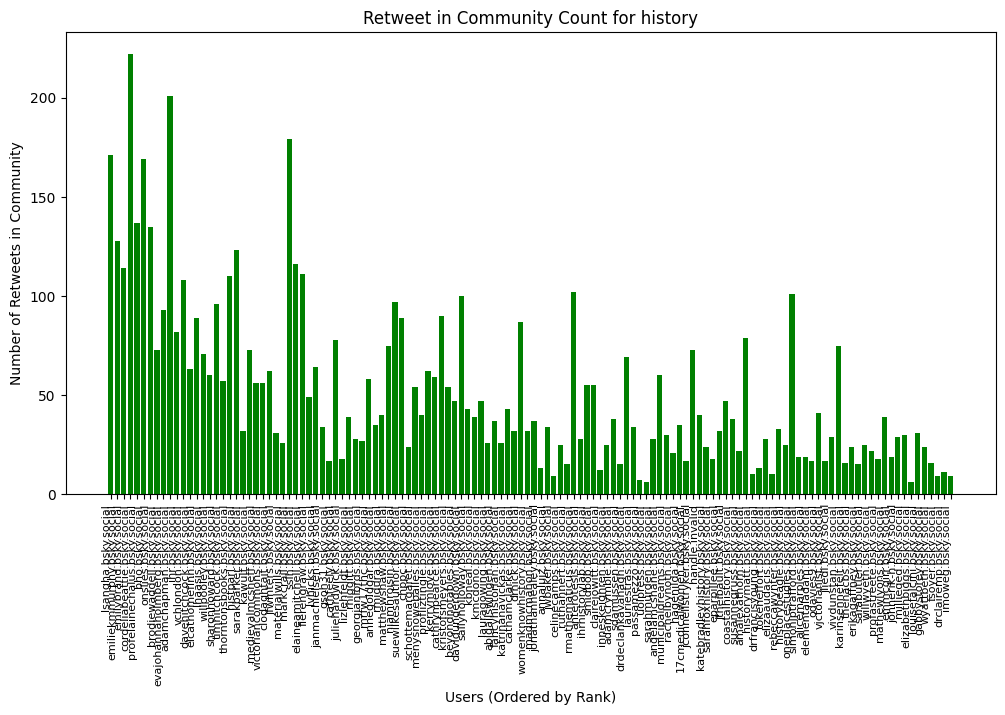

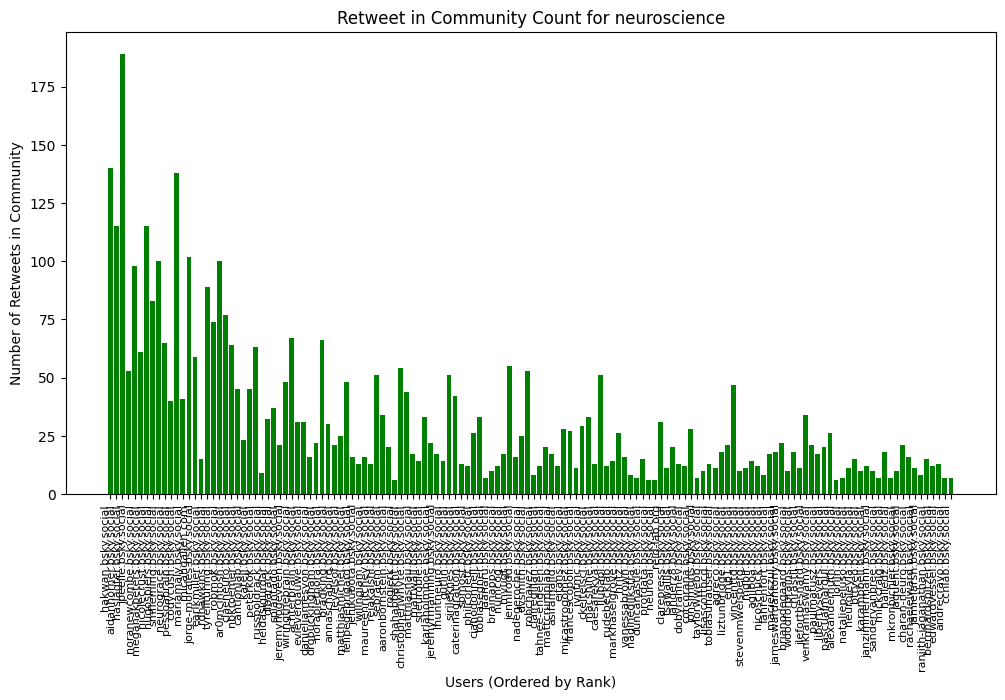

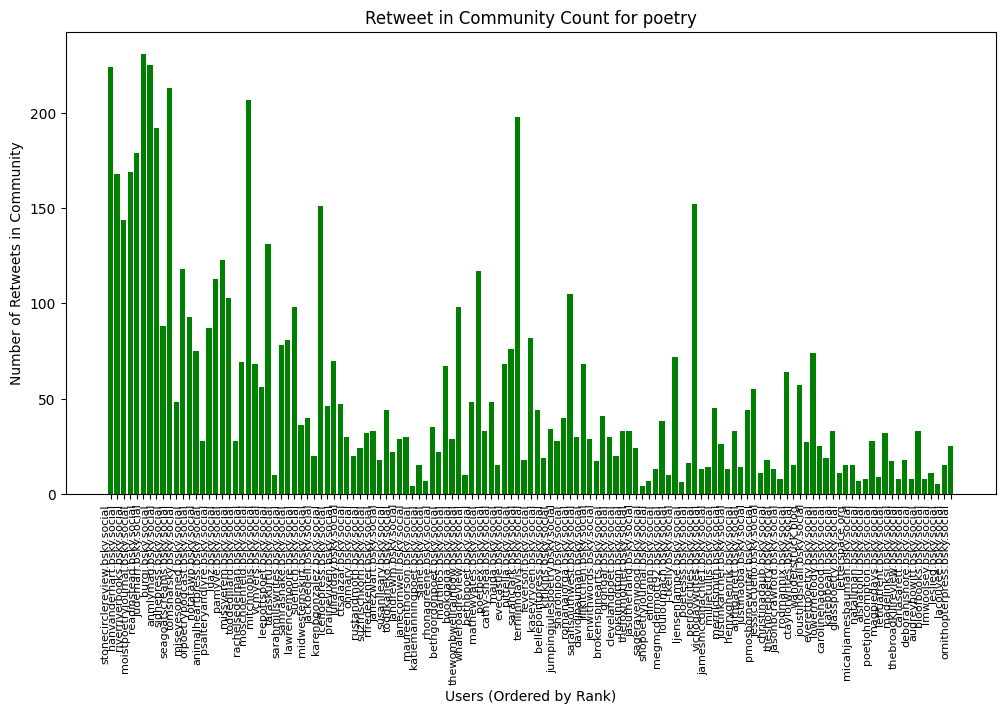

In [4]:
for db in communities:
    user_data = []
    user_collection = MONGO_CLIENT[db]['user_info']
    tweet_collection = MONGO_CLIENT[db]['retweets_of_in_community']

    users = user_collection.find({}, {"userid": 1, "username": 1, "rank": 1, "_id": 0}).sort("rank", 1)

    for user in users:
        user_id = user.get("userid")
        username = user.get("username")
        rank = user.get("rank")
        
        tweet_count = tweet_collection.count_documents({"user_id": user_id})
        
        user_data.append({"username": username, "rank": rank, "tweet_count": tweet_count})

    df = pd.DataFrame(user_data)

    df = df.sort_values(by="rank", ascending=True)

    plt.figure(figsize=(12, 6))
    plt.bar(df["username"], df["tweet_count"], color="green")
    plt.xlabel("Users (Ordered by Rank)")
    plt.ylabel("Number of Retweets in Community")
    plt.title(f"Retweet in Community Count for {db}")
    plt.xticks(rotation=90, ha="right", fontsize=8)
    plt.show()

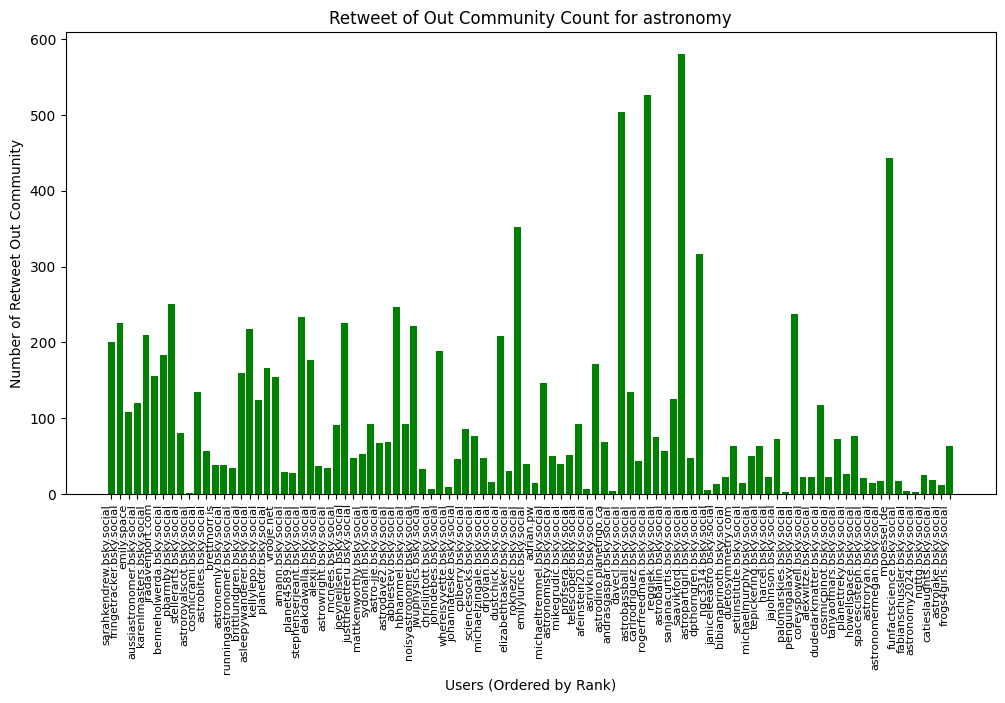

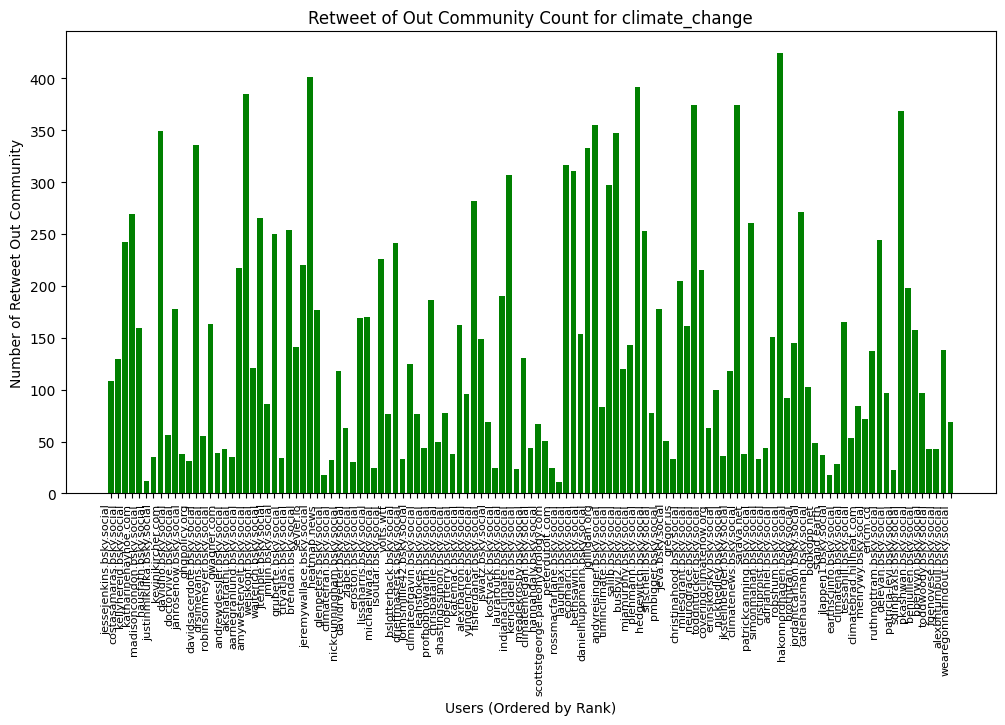

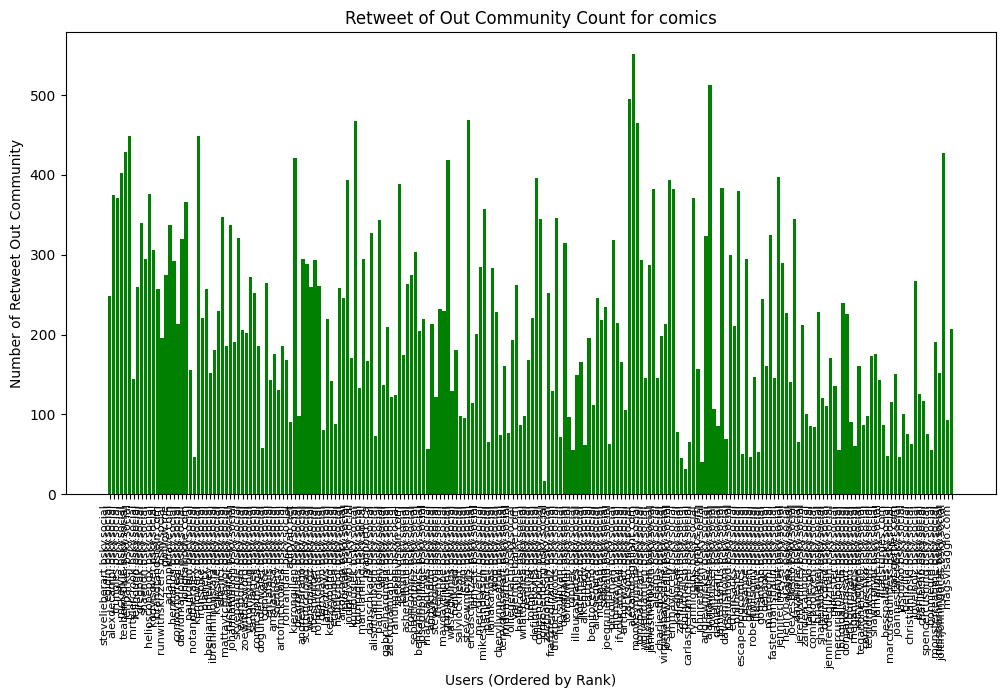

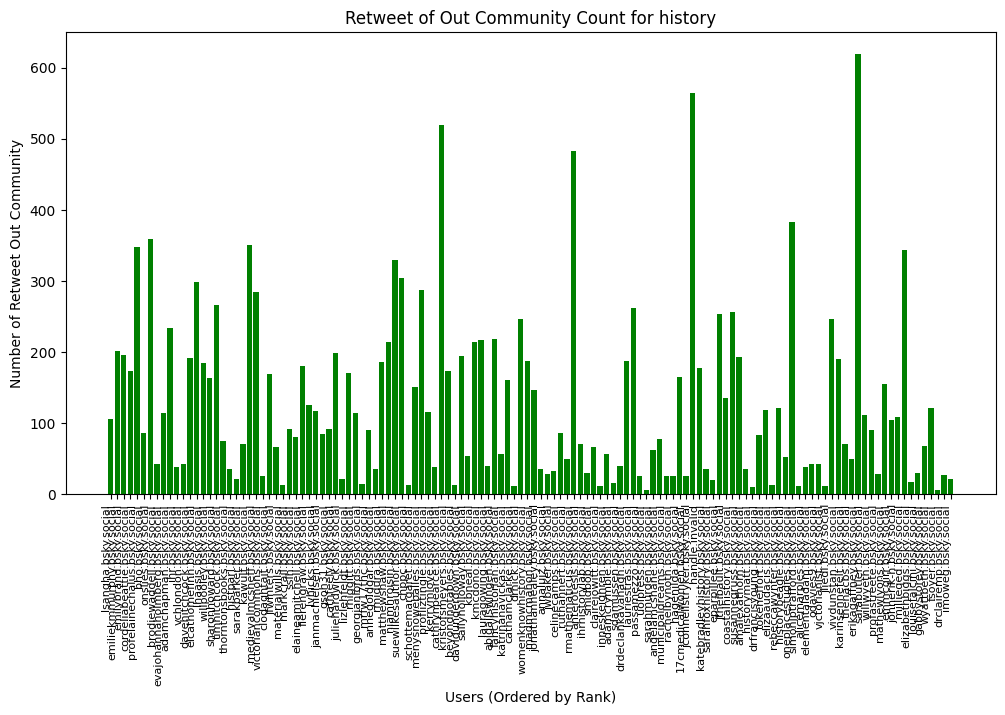

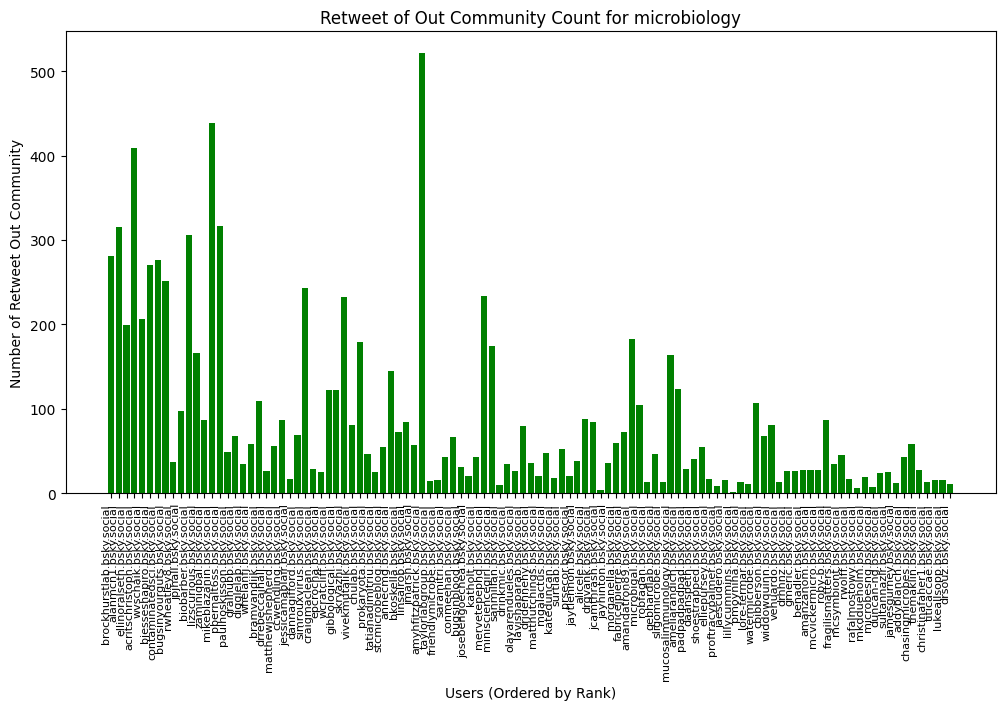

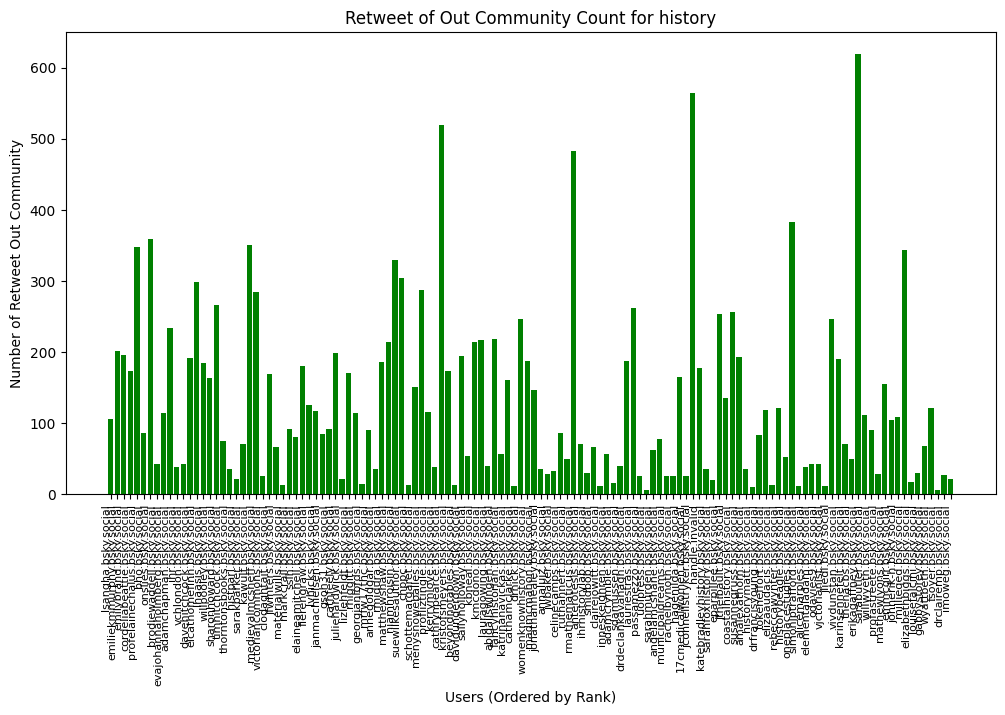

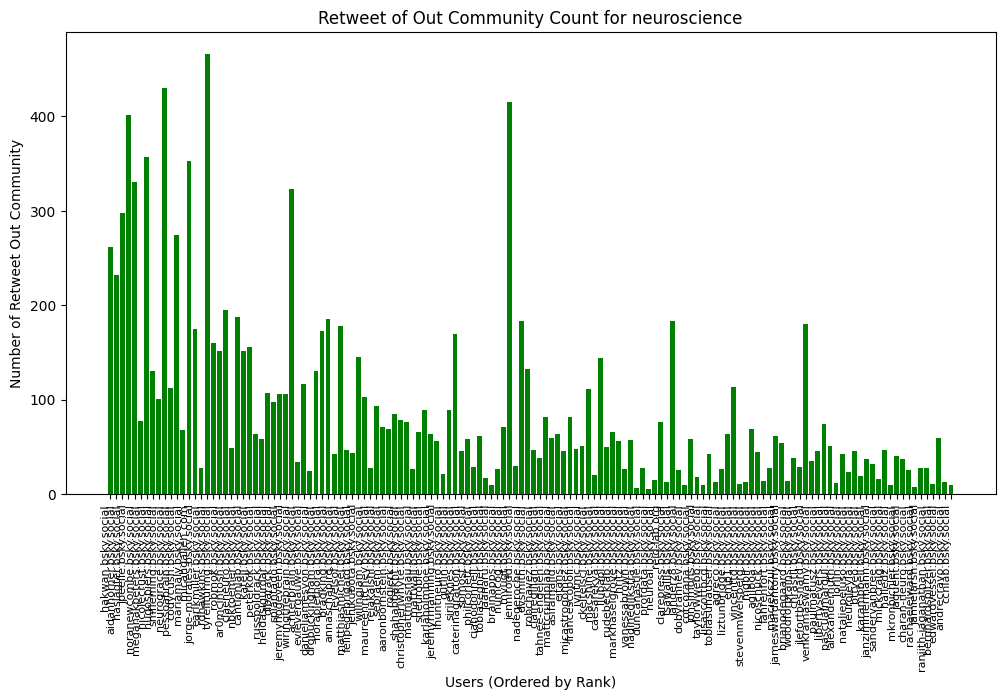

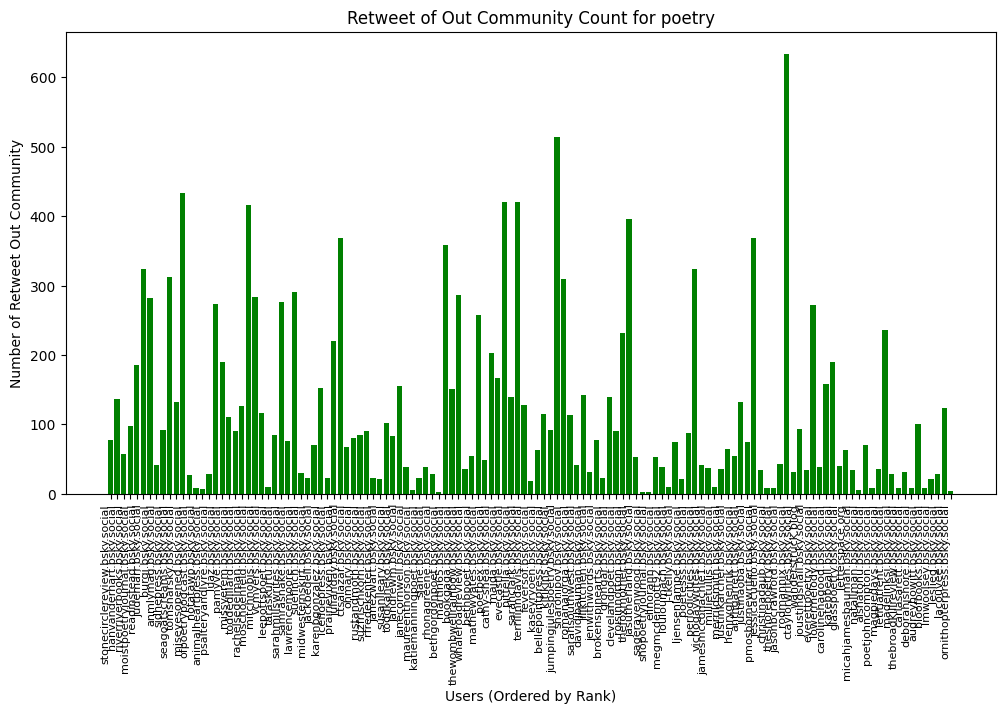

In [5]:
for db in communities:
    user_data = []
    user_collection = MONGO_CLIENT[db]['user_info']
    tweet_collection = MONGO_CLIENT[db]['retweets_of_out_community_by_in_community']

    users = user_collection.find({}, {"userid": 1, "username": 1, "rank": 1, "_id": 0}).sort("rank", 1)

    for user in users:
        user_id = user.get("userid")
        username = user.get("username")
        rank = user.get("rank")
              
        tweet_count = tweet_collection.count_documents({"user_id": user_id})
        
        user_data.append({"username": username, "rank": rank, "tweet_count": tweet_count})

    df = pd.DataFrame(user_data)

    df = df.sort_values(by="rank", ascending=True)

    plt.figure(figsize=(12, 6))
    plt.bar(df["username"], df["tweet_count"], color="green")
    plt.xlabel("Users (Ordered by Rank)")
    plt.ylabel("Number of Retweet Out Community")
    plt.title(f"Retweet of Out Community Count for {db}")
    plt.xticks(rotation=90, ha="right", fontsize=8)
    plt.show()